# Lab 3: MDP and QMDP
This lab aims to show you how to formulate a problem as an MDP (POMDP) and solve it using value iteration, policy iteration, and approximated solution for POMDP such as QMDP.

## 1. MDP
### Task 1.1: MDP formulation
We provide you with a class `MDP()` to help you easily formulate your MDP problem. Refer to your lab handout for instructions on how to use the class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from mdp import MDP

Test out the class with the simple two-state problem in the handout

In [2]:
class TwoStateMDP(MDP):
    def __init__(self):
        self.states = [["s1", "s2"]]
        self.actions = ["a0", "a1"]
        self.gam = 0.9
    
        # call the parent class
        # notice that the state is a list of state variables
        super().__init__(
            states=self.states, actions=self.actions)
        self.populate_data()
    
    def populate_data(self):
        # add all routes from s1
        self.add_route(["s1"],"a0",["s1"])
        self.add_route(["s1"],"a1",["s2"])
        # add all routes from s2
        self.add_route(["s2"],"a0",["s2"])
        self.add_route(["s2"],"a1",["s2"])
        
        # let's populate the reward, assuming r>0 is 0.5
        for a in self.a:
            self.add_reward(["s1"], a, 0.5)
            self.add_reward(["s2"], a, 1.5)

In [3]:
twoStateMDP = TwoStateMDP()
assert twoStateMDP.get_index(["s1"]) == 0, "Something is wrong"
assert twoStateMDP.get_state(0) == [0], "Something is wrong"
assert twoStateMDP.get_real_state_value(0) == ['s1'], "Something is wrong"
print("Everything is correct!")

Everything is correct!


Now let's use the `MDP()` class to formulate our T-intersection problem.

**Task 1.1**: In `populate_data()`, all the probability value for each `self.add_route()` command is missing (denotes `MISSING_VALUE`). Compute the state transition matrix of the T-intersection MDP and fill in the missing `p` values.

In [4]:
### TASK 1.1: Fill in MISSING_VALUE with correct p values
class TIntersection(MDP):
    def __init__(self, reward={"forward": -1.0, "stop": -5, "collision": -10, "goal": 5.0}):
        self.states = [
            ["ego_{}".format(x) for x in list(range(1, 6))],
            ["car_{}".format(x) for x in list(range(1, 6))]
        ]
        self.actions = ["forward", "stop"]
        self.gam = 0.9
        super().__init__(
            states=self.states, actions=self.actions, method="add")
        self.reward = reward
        self.populate_data()
    
    def populate_data(self):
        for i in range(1, 6):
            for j in range(1, 6):
                # add route for forward action
                # (i, j) --> (i+1, j)
                #if ego moves forward once, other car has a 0.8*0.8 = 0.64 chance of stopping
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(j)], round(0.64, 3))
                # (i, j) --> (i+1, j+1)
                #if ego moves forward one step other car moves 1 step, other car has a 0.8*0.2*0.8 = 0.16 
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(min(j+1, 5))], round(0.128, 3))
                # (i, j) --> (i+1, j+2)
                #if ego moves forward once and other car moves forward twice, its 0.8*0.2*0.2 = 0.032
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(min(j+2, 5))], round(0.032, 3))
                # (i, j) --> (i+2, j)
                #if ego moves forward 2 spaces and j stops, its 0.2*0.8 = 0.16
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(j)], round(0.16, 3))
                # (i, j) --> (i+2, j+1)
                #if ego moves forward twice and other car moves forward once, its 0.2*0.2*0.8
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(min(j+1, 5))], round(0.032, 3))
                # (i, j) --> (i+2, j+2)
                #if both move forward twice, its 0.2 * 0.2 * 0.2 = 0.008
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(min(j+2, 5))], round(0.008, 3))

                # add route for stop action
                # (i, j) --> (i, j+2)
                #when stopping, and other moves forward twice, its 0.4*0.2 = 0.08
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(min(j+2, 5))],  round(0.08, 3))
                # (i, j) --> (i, j+1)
                #when stopping, other moves forward once, 0.4 * 0.8 = 0.32
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(min(j+1, 5))], round(0.32, 3))
                # (i, j) --> (i, j)
                #when stopping, other stops, 0.6
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(j)], round(0.6,3))

                self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["forward"])
                self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["stop"])
                        
                # check for collision
                if (i in [4, 5]) and (j in [4, 5]):
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["collision"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["collision"])
                elif (i == 5) or (j == 5):
                    # reaching goal
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["goal"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["goal"])

In [5]:
### TEST YOUR CODE
tinter = TIntersection()
init_state = ["ego_1", "car_1"]
init_state_index = tinter.get_index(init_state)
state_transition_matrix = tinter.P[:, 0, init_state_index]
next_state_index = np.where(state_transition_matrix > 0.0)
next_state_p = state_transition_matrix[next_state_index]
assert np.array_equal(next_state_index[0], np.array([1, 2, 6, 7, 11, 12]))
assert np.array_equal(next_state_p, np.array([0.64, 0.16, 0.128, 0.032, 0.032, 0.008]))

print("Correct!")

Correct!


### Task 1.2: MDP value iteration and policy iteration
Now we will write the value iteration function and policy iteration function or an arbitrary MDP that inherits the structure of our MDP class

In [6]:
### TASK 1.2: Write value iteration and policy iteration
def value_iteration(threshold = .001, mdp:MDP=None):
    if mdp is None:
        raise ValueError("MDP cannot be None")
    numa, nums, R, P = mdp.get_mdp()
    V_star = np.zeros(nums)
    pi_star = np.zeros(nums)
    
    ####
    ## YOUR CODE HERE
    print(F"V_star: {V_star.shape} pi_star: {pi_star.shape}  numa: {numa} nums: {nums} R: {R.shape} P: {P.shape}")
    gamma = 0.1
    counter = 0
    delta = np.inf
    while True:
        for s in range(nums):
            v = V_star[s]
            V_star[s] = max(R[s, :] + twoStateMDP.gam * V_star @ P[:, s, :])
            delta = min(delta, abs(v-V_star[s]))                                       
        if delta < threshold:
            print("Value Iter: delta < threshold, breaking")
            break
        counter+=1
        if counter >=500:
            print("Value iteration: Went past counter of 500")
            break
    for s in range(nums):
        pi_star[s] = np.argmax(R[s, :] + twoStateMDP.gam * V_star @ P[:, s, :])
    #raise NotImplementedError("You have not written Value Iteration")
    ####
    
    return V_star, pi_star

def policy_eval(policy, threshold = .001, mdp:MDP=None):
    if mdp is None:
        raise ValueError("MDP cannot be None")
    numa, nums, R, P = mdp.get_mdp()
    V = np.zeros(nums)
    
    ####
    ## YOUR CODE HERE
    counter = 0
    delta = np.inf
    while True:
        
        for s in range(nums):
            v = V[s]
            a = policy[s]
            
            V[s] = sum(P[:, s, a] * (R[s, a] + twoStateMDP.gam * V[s])) 
            delta = min(delta, abs(v-V_star[s]))
        
        if delta < threshold:
            print("Policy Eval: delta < threshold, breaking")
            break
        counter+=1
        if counter >=100:
            print("Policy Eval: Went past counter of 100")
            break
    #raise NotImplementedError("You have not written Policy Evaluation")
    ####
    
    return V

def policy_iteration(threshold = .001, mdp:MDP=None):
    if mdp is None:
        raise ValueError("MDP cannot be None")
    numa, nums, R, P = mdp.get_mdp()
    # initialize a random policy with length nums and action randomly assigned from numa
    pi_star = np.random.randint(0, numa, nums)
    V_star = policy_eval(pi_star, mdp=mdp)
    print(f"PolicyIter: V_star: {V_star}")

    ####
    ## YOUR CODE HERE
    policy_stable = True
    while True:
        for s in range(nums):
            old_action = pi_star[s]
            V_star[s] = max(R[s, :] + twoStateMDP.gam * V_star @ P[:, s, :])
            pi_star[s] = np.argmax(P[:, s, :] @ (R[s, :] + twoStateMDP.gam * V_star))
            
            if (old_action != pi_star[s]):
                policy_stable = False
        if (not policy_stable):
            V_star = policy_eval(pi_star, mdp=mdp)
            policy_stable = True
        else:
            break
            
        
    #raise NotImplementedError("You have not written Policy Iteration")
    ####

    return V_star, pi_star

Let's test our value iteration and policy iteration on the `TwoStateMDP`. The following is the close-form value function for this simple MDP:

$$
V(s_1) = \frac{r + \gamma}{1 - \gamma} \;\;,\;\; V(s_2) = \frac{1 + r}{1 - \gamma}
$$

In [7]:
### TEST YOUR CODE
V_star, pi_star_value = value_iteration(mdp=twoStateMDP, threshold=1e-10)
r = 0.5
V_calc = [(r + twoStateMDP.gam)/(1-twoStateMDP.gam), (1 + r)/(1-twoStateMDP.gam)]
print(f"V_star: {V_star}  V_calc: {V_calc}")
assert np.max(abs(V_star - V_calc)) < 1e-2, "Value iteration is incorrect"
print("Value iteration is correct!")

V_star, pi_star_policy = policy_iteration(mdp=twoStateMDP, threshold=1e-10)
print(f"V_star: {V_star} V_calc: {V_calc}")
assert np.max(abs(V_star - V_calc)) < 1e-2, "Policy iteration is incorrect"
print("Policy iteration is correct!")

#assert np.array_equal(pi_star_policy, pi_star_value), "Policy and value iteration give different pi star"
print("Policy learned by value iteration: {}".format(pi_star_value))
print("Policy learned by policy iteration: {}".format(pi_star_policy))

V_star: (2,) pi_star: (2,)  numa: 2 nums: 2 R: (2, 2) P: (2, 2, 2)
Value Iter: delta < threshold, breaking
V_star: [14. 15.]  V_calc: [14.000000000000002, 15.000000000000004]
Value iteration is correct!
Policy Eval: delta < threshold, breaking
PolicyIter: V_star: [ 4.99972233 14.999167  ]
Policy Eval: delta < threshold, breaking
V_star: [13.9992503 14.9992503] V_calc: [14.000000000000002, 15.000000000000004]
Policy iteration is correct!
Policy learned by value iteration: [1. 0.]
Policy learned by policy iteration: [1 1]


Let's now test the value iteration and policy iteration on our T-intersection MDP

In [8]:
V_star, pi_star = value_iteration(mdp=tinter, threshold=1e-5)
print("V*: {}".format(V_star))
print("pi*: {}".format(pi_star))

V_star: (25,) pi_star: (25,)  numa: 2 nums: 25 R: (25, 2) P: (25, 25, 2)
Value Iter: delta < threshold, breaking
V*: [ -4.44764571  -5.86514155  -6.86984388  -3.82025674   2.17974326
   4.08969386   2.72600519   2.72600519 -24.87710805 -18.87710805
  15.41754789  14.65006207  14.65006207 -52.42812846 -46.42812846
  28.3476046   28.26064808  28.26064808 -99.99955703 -99.99955703
  49.99977852  49.99977852  49.99977852 -99.99955703 -99.99955703]
pi*: [0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 0.]


### Task 1.3: Simulate your computed $\pi^*$

We provide you with a class `TintersectionVisualizer()` to visualize your MDP. Simply call the following function to plot the current state:
```python
# initialize the visualizer
vis = TIntersectionVisualizer()
# define the state
state = ["ego_1", "car_1"]
# visualize the state
vis.plot(state)
```

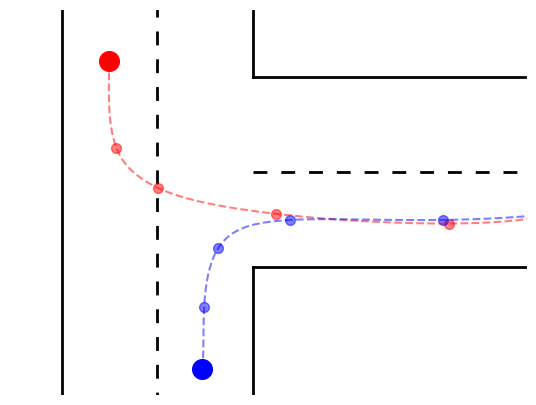

In [9]:
from visualizer import TIntersectionVisualizer
vis = TIntersectionVisualizer()
state = ["ego_1", "car_1"]
vis.plot(state)

Do the following task:
1. Choose an initial state
2. From the computed $V^*(x), \pi^*(x)$, iterate from the chosen initial state gradually until you reach the terminal state, i.e. `["ego_5", "car_5"]`.
3. While iterating, keep track of your state-action pair $(s, a)$. Print out all the state-action pairs that your computed $V^*(x), \pi^*(x)$ navigate you to.

*Hint 1*: For each state and action pair $(s, a)$, the matrix P will show you the probability of $s'$ by calling `P[:, state_index, action_index]`

*Hint 2*: Assuming that you have a list of states `S` and the probability distribution `p` of the states in `S`, you can use `numpy.random.choice(S, p=p)` to sample the next state, given `S` and `p`.

In [10]:
## YOUR CODE HERE
"""
### TEST YOUR CODE
tinter = TIntersection()
init_state = ["ego_1", "car_1"]
init_state_index = tinter.get_index(init_state)
state_transition_matrix = tinter.P[:, 0, init_state_index]
next_state_index = np.where(state_transition_matrix > 0.0)
next_state_p = state_transition_matrix[next_state_index]
assert np.array_equal(next_state_index[0], np.array([1, 2, 6, 7, 11, 12]))
assert np.array_equal(next_state_p, np.array([0.64, 0.16, 0.128, 0.032, 0.032, 0.008]))
"""

V_star, pi_star = value_iteration(mdp=tinter, threshold=1e-5)
def get_solution(initial_state):
    done = False
    state = initial_state 
    state_list = [state]
    print("State: {}\tAction: {}".format(state, None))

    while not done:
        ## YOUR CODE HERE
        # 1. Get index of current state
        # 2. Get next action based on pi_star and state index
        # 3. Get indices of all the possible next states and their transition probabilities
        # 4. Sample next state index, given the transition probabilities
        # 5. Append new state (readable form, e.g. ["ego_1", "car_2"]) to state_list

        #1
        curr_state = state_list[-1]
        curr_state_index = tinter.get_index(curr_state)

        #2
        next_action = int(pi_star[curr_state_index])

        #3
        #P is new_state, state, action
        state_transition_matrix = tinter.P[:, curr_state_index, next_action]
        next_state_index = np.where(state_transition_matrix > 0.0)
        next_state_p = state_transition_matrix[next_state_index]

        #4
        next_state_index = np.concatenate(next_state_index)
        next_state = np.random.choice(next_state_index, p=next_state_p)
        
        #5
        state_list.append(tinter.get_real_state_value(next_state))

        #keep track
        print("State: {}\tAction: {}".format(curr_state, next_action))
        #print(curr_state)
        
        if state_list[-1][0] == "ego_5" or state_list[-1][1] == "car_5":
            print("State: {}\tAction: {}".format(state_list[-1], next_action))
            print("done")
            done = True

    return state_list

initial_state = ["ego_1", "car_1"] # choose an initial condition
state_list = get_solution(initial_state)

V_star: (25,) pi_star: (25,)  numa: 2 nums: 25 R: (25, 2) P: (25, 25, 2)
Value Iter: delta < threshold, breaking
State: ['ego_1', 'car_1']	Action: None
State: ['ego_1', 'car_1']	Action: 0
State: ['ego_2', 'car_1']	Action: 0
State: ['ego_3', 'car_2']	Action: 1
State: ['ego_3', 'car_3']	Action: 1
State: ['ego_3', 'car_3']	Action: 1
State: ['ego_3', 'car_3']	Action: 1
State: ['ego_3', 'car_3']	Action: 1
State: ['ego_3', 'car_4']	Action: 1
State: ['ego_3', 'car_5']	Action: 1
done


/tmp/ipykernel_1371/1735534440.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


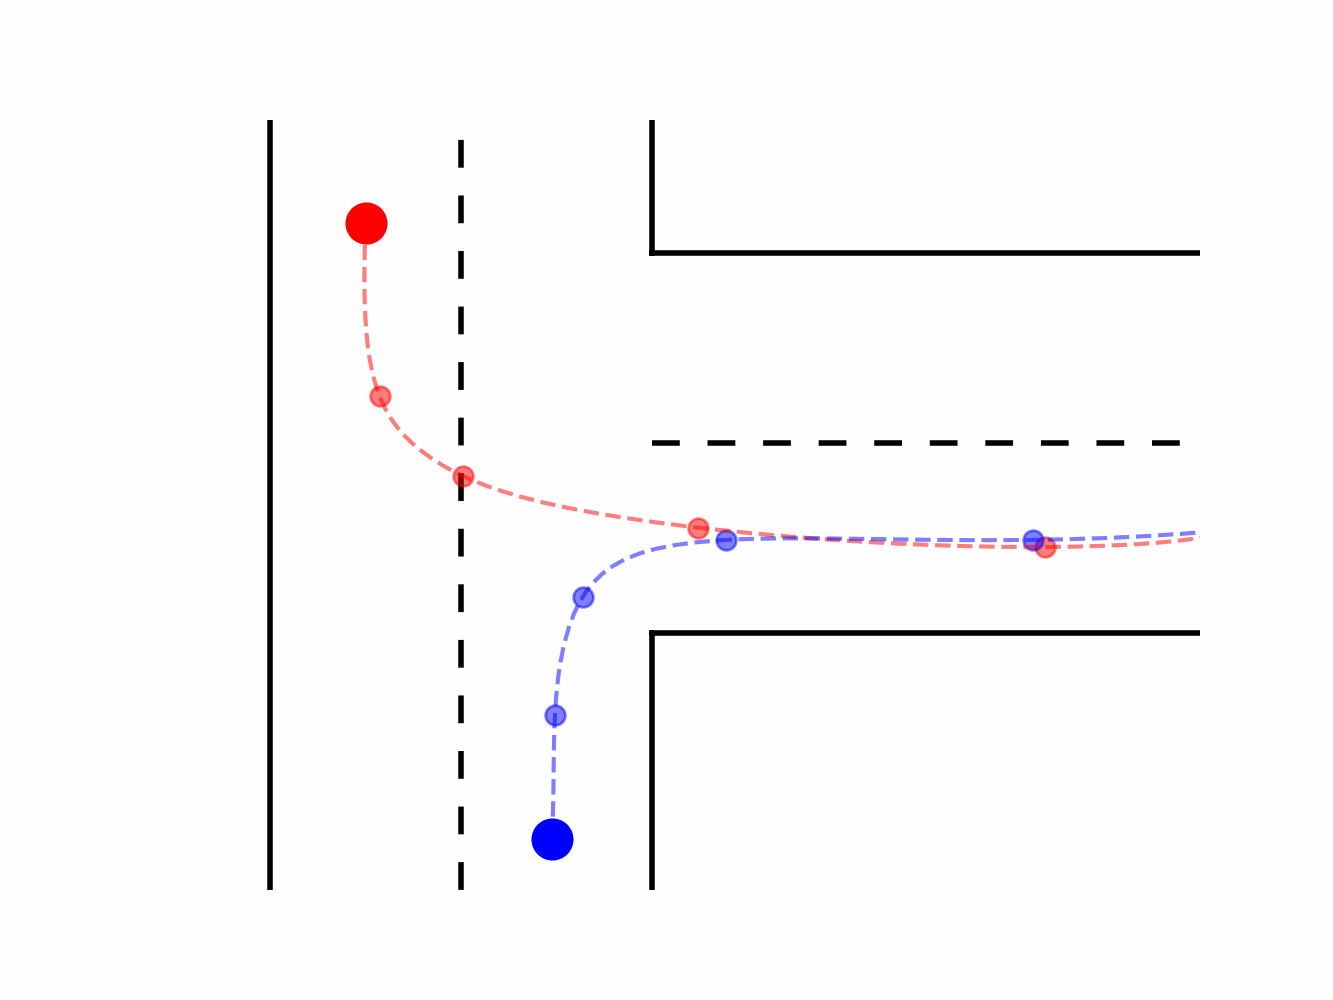

<Figure size 666.667x500 with 0 Axes>

In [11]:
import imageio
from IPython.display import Image

folder = "figures"
sub_folder = "mdp"

fig_prog_folder = os.path.join(folder, sub_folder)
if os.path.exists(fig_prog_folder):
    print("WARNING: Path {} exists, GIF result might be affected with old data".format(fig_prog_folder))
os.makedirs(fig_prog_folder, exist_ok=True)

for i, state in enumerate(state_list):
    vis.plot(state)
    plt.savefig(os.path.join(fig_prog_folder, "{}.png".format(i)), dpi=200)
    plt.clf()

gif_path = os.path.join(fig_prog_folder, 'result.gif')
length = len([i for i in os.listdir(os.path.join(fig_prog_folder)) if ".png" in i])

with imageio.get_writer(gif_path, mode='I') as writer:
    for i in range(length):
        print(i, end='\r')
        filename = os.path.join(fig_prog_folder, str(i)+".png")
        image = imageio.imread(filename)
        writer.append_data(image)
Image(open(gif_path,'rb').read(), width=400)

Let's play around with this a bit. Let's change the default reward function of our MDP.

The class `TIntersection()` takes in a dictionary with reward information of the following structure:

```python
TIntersection(reward = {
    "forward": forward_r,
    "stop": stop_r,
    "collision": collision_r,
    "goal": goal_r
})
```

Let's change the reward function and see how it affects the $\pi^*$

In [12]:
tinter = TIntersection(reward={
    "forward": 0.0,
    "stop": -1.0,
    "collision": -100,
    "goal": 20
})

In [13]:
V_star, pi_star = value_iteration(mdp=tinter, threshold=1e-5)
print("V*: {}".format(V_star))
print("pi*: {}".format(pi_star))

V_star: (25,) pi_star: (25,)  numa: 2 nums: 25 R: (25, 2) P: (25, 25, 2)
Value Iter: delta < threshold, breaking
V*: [   0.    0.    0.    0.   20.    0.    0.    0.    0.   20.    0.    0.
    0.    0.   20.    0.    0.    0. -100. -100.   20.   20.   20. -100.
 -100.]
pi*: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 0.]


In [14]:
initial_state = ["ego_1", "car_1"] # choose an initial state
get_solution(initial_state)

State: ['ego_1', 'car_1']	Action: None
State: ['ego_1', 'car_1']	Action: 0
State: ['ego_2', 'car_1']	Action: 0
State: ['ego_4', 'car_1']	Action: 0
State: ['ego_5', 'car_1']	Action: 0
done


[['ego_1', 'car_1'],
 ['ego_2', 'car_1'],
 ['ego_4', 'car_1'],
 ['ego_5', 'car_1']]

With this new reward function, it is not good almost everywhere to choose the action 0, i.e. forward.

## 2. QMDP
### Task 2.1: Defining new MDP
Assume that in this new problem, we do not know exactly where the other car is. Let's introduce a new action called *look* into our problem formulation. Everytime we choose the action *look*, no car moves, we get a $-1$ reward, and receives the observation $z \in \{1 \dots 5\}$ corresponding to the position of the other car.

The first thing we will do to approximate this POMDP with QMDP is to solve for the underlying MDP formulation (assuming that all states are fully observable).

Tasks:
1. Edit the class `TIntersection()` to include the new information mentioned
2. Use value iteration/policy iteration and solve for $\hat{V}^{\text{MDP}}$

**NOTE**: You can copy the value of all the missing probability values from the previous questions (denotes `MISSING_VALUE`)

In [15]:
class TIntersectionQMDP(MDP):
    def __init__(self, reward={"forward": -1, "stop": -5, "collision": -10, "goal": 5.0, "look": -1}):
        self.states = [
            ["ego_{}".format(x) for x in list(range(1, 6))],
            ["car_{}".format(x) for x in list(range(1, 6))]
        ]
        
        # 1. Add another action "look" to self.actions
        self.actions = ["forward", "stop", "look"]

        self.gam = 0.9
        super().__init__(
            states=self.states, actions=self.actions, method="add")
        self.reward = reward
        self.populate_data()
        
    def populate_data(self):
        for i in range(1, 6):
            for j in range(1, 6):
                # add route for forward action
                # (i, j) --> (i+1, j)
                #if ego moves forward once, other car has a 0.8*0.8 = 0.64 chance of stopping
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(j)], 0.64)
                # (i, j) --> (i+1, j+1)
                #if ego moves forward one step other car moves 1 step, other car has a 0.8*0.2*0.8 = 0.16 
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(min(j+1, 5))], 0.128)
                # (i, j) --> (i+1, j+2)
                #if ego moves forward once and other car moves forward twice, its 0.8*0.2*0.2 = 0.032
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(min(j+2, 5))], 0.032)
                # (i, j) --> (i+2, j)
                #if ego moves forward 2 spaces and j stops, its 0.2*0.8 = 0.16
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(j)], 0.16)
                # (i, j) --> (i+2, j+1)
                #if ego moves forward twice and other car moves forward once, its 0.2*0.2*0.8
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(min(j+1, 5))], 0.032)
                # (i, j) --> (i+2, j+2)
                #if both move forward twice, its 0.2 * 0.2 * 0.2 = 0.008
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(min(j+2, 5))], 0.008)

                # add route for stop action
                # (i, j) --> (i, j+2)
                #when stopping, and other moves forward twice, its 0.4*0.2 = 0.08
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(min(j+2, 5))], 0.08)
                # (i, j) --> (i, j+1)
                #when stopping, other moves forward once, 0.4 * 0.8 = 0.32
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(min(j+1, 5))], 0.32)
                # (i, j) --> (i, j)
                #when stopping, other stops, 0.6
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(j)], 0.6)


                self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["forward"])
                self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["stop"])

                # add route and reward for look action
                ## YOUR CODE HERE
                # self.add_route(...., "look", ...., p=...)
                # ...
                # self.add_reward(..., "look", self.reward["look"])
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "look", ["ego_{}".format(i), "car_{}".format(j)], 1)
                self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "look", self.reward["look"])
                
                ######
                        
                # check for collision
                if (i in [4, 5]) and (j in [4, 5]):
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["collision"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["collision"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "look", self.reward["collision"])
                elif (i == 5) or (j == 5):
                    # reaching goal
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["goal"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["goal"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "look", self.reward["goal"])

In [16]:
tinter_qmdp = TIntersectionQMDP()

### Task 2.2: QMDP
Write the QMDP function to get the **next action**, taking in consideration the belief space.

In [17]:
# calculate the V_star using previously built value iteration
V_star, pi_star = value_iteration(mdp=tinter_qmdp, threshold=1e-4)

V_star: (25,) pi_star: (25,)  numa: 3 nums: 25 R: (25, 3) P: (25, 25, 3)
Value Iter: delta < threshold, breaking


In [18]:
def QMDP(V_star, belief, mdp:MDP=None):
    if mdp is None:
        raise ValueError("MDP cannot be None")
    
    numa, nums, R, P = mdp.get_mdp()

    # compute MDP-value for state-action pairs (Q)
    ####
    Q_values = np.zeros((nums, numa))
    ## YOUR CODE HERE
    for s in range(nums):
        for a in range(numa):
            #print(f"Q_valuesshape {Q_values.shape}")
            #print(f"V_starshape: {V_star.shape} Pshape: {P[:,s,a].shape}")
            #print(f"V_star: {V_star} P: {P[:,s,a]}")
            Q_values[s, a] = R[s, a] + sum(V_star * P[:, s, a] )
        
    #raise NotImplementedError("Your QMDP function is empty")

    ####
    return np.argmax(belief @ Q_values)

As we know exactly where we are all the time, and we only do not know where the other car is. Let us keep track of the probability distribution of where the other car is using an array of `b = [p_1, p_2, p_3, p_4, p_5]`, with `p_i` indicates the probability that the other car is at the $i^\text{th}$ position, $i \in \{1 \dots 5\}$.

We then provide you with the function `propagate_belief()` to incorporate our current position to give you the full array of belief space $\in \mathbb{R}^{25}$

**Example**: Let us have our current belief `b = [0.2, 0.2, 0.2, 0.2, 0.2]` and that we are at `ego_1`, running `propagate_belief(b, "ego_1")` gives us:

```python
propagate_belief(b, "ego_1")
>>> [0.2 0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.2 0.  0.
 0.  0.  0.2 0.  0.  0.  0. ]
```

This is because the state array is in the form `[(ego_1, car_1), (ego_1, car_2), ..., (ego_2, car_1), (ego_2, car_2), ..., (ego_5, car_5)]`.

In [19]:
# assume that the initial belief space is {0.2, 0.2, 0.2, 0.2, 0.2} for the 5 positions that the other car can be in
# if *look* is chosen, we will receive the observation of where the other car is, with probability distribution 
# p(pos-1) = 0.1, p(pos)=0.8, p(pos+1)=0.1 with pos is the true position
b = [0.2, 0.2, 0.2, 0.2, 0.2]

# write a function to propagate the belief space to include our position as well
def propagate_belief(b_car, ego_state):
    idx = int(ego_state.replace("ego_", "")) - 1
    b_full = np.zeros(25)
    for i, p in enumerate(b_car):
        b_full[i*5 + idx] = p
    return b_full

print(propagate_belief(b, "ego_1"))

[0.2 0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.2 0.  0.
 0.  0.  0.2 0.  0.  0.  0. ]


In [20]:
## TEST YOUR CODE
# we know exactly where we are, and we are confident that the other car is at position 1
belief = propagate_belief([1.0, 0.0, 0.0, 0.0, 0.0], "ego_1")
next_action = QMDP(V_star, belief, mdp=tinter_qmdp)
print("Best next action: {}".format(next_action))

# we know exactly where we are, and we are confident that the other car is at position 3
belief = propagate_belief([0.0, 0.0, 1.0, 0.0, 0.0], "ego_3")
next_action = QMDP(V_star, belief, mdp=tinter_qmdp)
print("Best next action: {}".format(next_action))

# we know exactly where we are, and we are not that confident where the other is, with high prop that
# it's around position 2 or 3
belief = propagate_belief([0.0, 0.4, 0.5, 0.1, 0.0], "ego_3")
next_action = QMDP(V_star, belief, mdp=tinter_qmdp)
print("Best next action: {}".format(next_action))

Best next action: 0
Best next action: 1
Best next action: 2


### Task 2.3: Observation and belief space

In [21]:
# assume that the initial belief space is {0.2, 0.2, 0.2, 0.2, 0.2} for the 5 positions that the other car can be in
# if *look* is chosen, we will receive the observation of where the other car is, with probability distribution 
# p(pos-1) = 0.1, p(pos)=0.8, p(pos+1)=0.1 with pos is the true position
b = [0.2, 0.2, 0.2, 0.2, 0.2]

# write a function to propagate the belief space to include our position as well
def propagate_belief(b_car, ego_state):
    idx = int(ego_state.replace("ego_", "")) - 1
    b_full = np.zeros(25)
    for i, p in enumerate(b_car):
        b_full[i*5 + idx] = p
    return b_full

We will use Bayesian inference to update our belief using the observation, and we will model our belief space as a multinomial distribution, so that we can easily do Bayesian inference with conjugate prior. In this case, it will be Dirichlet distribution.

In [22]:
class DirichletMultinominal:
    def __init__(self, alpha=[1, 1, 1, 1, 1]):
        self.alpha = alpha
        self.observations = []
    
    def reset(self):
        self.observations = []
    
    def get_posterior_predictive(self, observations=[]):
        ### YOUR CODE HERE
        # 1. Append the new observations to the internal observation list
        # 2. Calculate the predictive posterior distribution and return
        self.observations.extend(observations)
        N = len(self.observations)
        alpha_len = len(self.alpha)
        distribution = []
        

        for i in range(alpha_len):
            alpha_amount = self.observations.count(i)
            distribution.append((self.alpha[i] + alpha_amount) / (alpha_len + N))
        
        #raise NotImplementedError
        ###
        return distribution


In [23]:
### TEST YOUR CODE
dist = DirichletMultinominal()
assert dist.get_posterior_predictive() == [0.2, 0.2, 0.2, 0.2, 0.2]
assert dist.get_posterior_predictive(observations=[0, 0, 0, 0, 0]) == [0.6, 0.1, 0.1, 0.1, 0.1]
dist.reset()
assert dist.get_posterior_predictive(observations=[1, 1, 1, 1, 1]) == [0.1, 0.6, 0.1, 0.1, 0.1]
print("Everything is correct!")

Everything is correct!


Run the last block to simulate our QMDP. Does the result make sense?

Run it a few times, as well as changing the initial state so that you can see different results.

In [24]:
done = False
state = ["ego_1", "car_1"]
state_list = [state]
b = dist.get_posterior_predictive()
print("State: {}\tAction: {}\tBelief: {}".format(state, None, b))

while not done:
    belief = propagate_belief(b, state[0])
    next_action = QMDP(V_star=V_star, belief=belief, mdp=tinter_qmdp)
    
    if int(next_action) == 2:
        true_state_idx = int(state[1].replace("car_", "")) - 1
        obs = np.random.choice([min(true_state_idx-1, 0), true_state_idx, min(true_state_idx+1, 4)], p=[0.1, 0.8, 0.1])
        b = dist.get_posterior_predictive([obs])
    elif int(next_action) == 0:
        dist.reset()
        b = dist.get_posterior_predictive()

    state_index = tinter_qmdp.get_index(state)

    next_state_indices = np.where(tinter_qmdp.P[:, state_index, int(next_action)] > 0.0)[0]
    next_state_p = tinter_qmdp.P[:, state_index, int(next_action)][next_state_indices]
    next_state_index = np.random.choice(next_state_indices, p=next_state_p)
    
    state = tinter_qmdp.get_real_state_value(next_state_index)
    state_list.append(state)

    if state[0] == "ego_5" or state[1] == "car_5":
        done = True
    
    print("State: {}\tAction: {}\tBelief: {}".format(state, next_action, b))

State: ['ego_1', 'car_1']	Action: None	Belief: [0.1, 0.6, 0.1, 0.1, 0.1]
State: ['ego_2', 'car_1']	Action: 0	Belief: [0.2, 0.2, 0.2, 0.2, 0.2]
State: ['ego_2', 'car_1']	Action: 2	Belief: [0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
State: ['ego_2', 'car_1']	Action: 2	Belief: [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285]
State: ['ego_2', 'car_1']	Action: 2	Belief: [0.25, 0.125, 0.125, 0.125, 0.125]
State: ['ego_2', 'car_1']	Action: 2	Belief: [0.3333333333333333, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111]
State: ['ego_2', 'car_1']	Action: 2	Belief: [0.3, 0.1, 0.1, 0.1, 0.1]
State: ['ego_2', 'car_1']	Action: 2	Belief: [0.36363636363636365, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091]
State: ['ego_2', 'car_1']	Action: 2	Belief: [0.4166666666666667, 0.08333333333333333, 0.08333333333333333, 0.083333